# <center>  Twitter hate tweets detection </center>

In [1]:
# !pip install -q --upgrade wordcloud
# !pip install -q --upgrade PyAudio
# !pip install -q --upgrade pyttsx3
# !pip install -q --upgrade SpeechRecognition


### Importing Libraries

In [2]:
#-------------------------------------------------------------------------------------------------------------------------------
import re                                                           # To perform regular expression based operations
import pandas as pd                                                 # Importing for panel data analysis
pd.set_option('display.max_columns', None)                          # Unfolding hidden features if the cardinality is high
pd.set_option('display.max_colwidth', None)                         # Unfolding the max feature width for better clearity
pd.set_option('mode.chained_assignment', None)                      # Removing restriction over chained assignments operations
#-------------------------------------------------------------------------------------------------------------------------------
import matplotlib.pyplot as plt                                     # Importing pyplot interface using matplotlib
from wordcloud import WordCloud                                     # To generate wordcloud from the text documents
%matplotlib inline
#-------------------------------------------------------------------------------------------------------------------------------
import pyttsx3                                                      # Text to speech conversion library
import pyaudio                                                      # Cross-platform audio input/output stream library
import speech_recognition as sr                                     # For performing speech recognition operations
import wave                                                         # The audio file format of WAV
#-------------------------------------------------------------------------------------------------------------------------------
import nltk                                                         # Toolkit to peform natural language processing
nltk.download('stopwords')
nltk.download('wordnet')
from nltk.corpus import stopwords                                   # Stopwords corpus
from nltk.stem import WordNetLemmatizer                             # To perform word lemmatization operations
#-------------------------------------------------------------------------------------------------------------------------------
from sklearn.feature_extraction.text import TfidfVectorizer         # To transform text data to vector form
from sklearn.naive_bayes import MultinomialNB                       # To develop multionmial naive bayse classfier
from sklearn.linear_model import LogisticRegression                 # To develop logistic regression classfier
from sklearn.model_selection import train_test_split                # To split data into training and testing part
from sklearn.metrics import classification_report                   # To check model performance using a report
#-------------------------------------------------------------------------------------------------------------------------------
import warnings                                                     # Importing warning to disable runtime warnings
warnings.filterwarnings("ignore")                                   # Warnings will appear only once

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\admin\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\admin\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!



# Data Acquisition & Description


In [3]:
train_data = pd.read_csv(filepath_or_buffer='https://gitlab.com/coldperformer/multimedia/-/raw/main/machine-learning-projects/data/05-twitter-hate-train.csv')
print('Data Shape:', train_data.shape)
train_data.head()

Data Shape: (31962, 2)


,label,tweet
0,0,@user when a father is dysfunctional and is so selfish he drags his kids into his dysfunction. #run
1,0,@user @user thanks for #lyft credit i can't use cause they don't offer wheelchair vans in pdx. #disapointed #getthanked
2,0,bihday your majesty
3,0,#model i love u take with u all the time in urð±!!! ðððð ð¦ð¦ð¦
4,0,factsguide: society now #motivation


In [4]:
test_data = pd.read_csv(filepath_or_buffer='https://gitlab.com/coldperformer/multimedia/-/raw/main/machine-learning-projects/data/06-twitter-hate-test.csv')
print('Data Shape:', test_data.shape)
test_data.head()

Data Shape: (17197, 1)


,tweet
0,#studiolife #aislife #requires #passion #dedication #willpower to find #newmaterialsâ¦
1,@user #white #supremacists want everyone to see the new â #birdsâ #movie â and hereâs why
2,safe ways to heal your #acne!! #altwaystoheal #healthy #healing!!
3,"is the hp and the cursed child book up for reservations already? if yes, where? if no, when? ððð #harrypotter #pottermore #favorite"
4,"3rd #bihday to my amazing, hilarious #nephew eli ahmir! uncle dave loves you and missesâ¦"



### Data Information

In [5]:
train_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 31962 entries, 0 to 31961
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   label   31962 non-null  int64 
 1   tweet   31962 non-null  object
dtypes: int64(1), object(1)
memory usage: 499.5+ KB


In [6]:
test_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 17197 entries, 0 to 17196
Data columns (total 1 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   tweet   17197 non-null  object
dtypes: object(1)
memory usage: 134.5+ KB



#  Data Pre-Processing


<a name = Section51></a>
### **Identification and Handling of Missing Values**

In [7]:
train_data.isnull().sum()

label    0
tweet    0
dtype: int64

In [8]:
test_data.isnull().sum()

tweet    0
dtype: int64

<a name = Section52></a>
### **Identification and Handling of Duplicate Values**

In [9]:
print('Duplicates in Train Data:', train_data.duplicated().sum())
print('Duplicates in Test Data:', test_data.duplicated().sum())

Duplicates in Train Data: 2432
Duplicates in Test Data: 1067


In [10]:
print('Old Train Shape:', train_data.shape)
print('Old Test Shape:', test_data.shape)

train_data.drop_duplicates(inplace=True)
test_data.drop_duplicates(inplace=True)
print('Duplicate data rows dropped!')

print('New Train Shape:', train_data.shape)
print('New Test Shape:', test_data.shape)

Old Train Shape: (31962, 2)
Old Test Shape: (17197, 1)
Duplicate data rows dropped!
New Train Shape: (29530, 2)
New Test Shape: (16130, 1)


In [11]:
print('Duplicates in Train Data:', train_data.duplicated().sum())
print('Duplicates in Test Data:', test_data.duplicated().sum())

Duplicates in Train Data: 0
Duplicates in Test Data: 0


<a name = Section53></a>
### **Text Cleaning**

In [12]:
stop_words = stopwords.words('english')
stop_words.append('movie')

def clean_data(text):
    """Cleans text data containing punctuation, stopwords, emoticons, lemmas, and non-ascii characters."""

    # Removing punctuation, stopwords, and emoticons
    text = re.sub('<[^>]*>', '', text)
    text = re.sub(r'[0-9]', '', text)
    emoticons = re.findall('(?::|;|=)(?:-)', text)
    text = (re.sub('[\W]+', ' ', text.lower()) +' '.join(emoticons).replace('-', ''))
    rm_words = [w for w in text.split() if w.lower() not in stop_words]

    # Performing Lemmatization
    lemmatizer = WordNetLemmatizer()
    lemma_words = [lemmatizer.lemmatize(word) for word in rm_words]

    # Removing non-ascii characters
    non_ascii_words = list()
    for word in lemma_words:
        for character in word:
            if ord(character) > 128:
                word = word.replace(character, '')
        non_ascii_words.append(word)

    # Removing empty string values from the list
    non_ascii_words = list(filter(None, non_ascii_words))
    
    return ' '.join(non_ascii_words)

clean_data('hello john!-;/.,<>? how are you.. @#$%^&*I am fine movie:')

'hello john fine'

In [13]:
train_data['tweet'] = train_data['tweet'].apply(clean_data)
train_data.head()

,label,tweet
0,0,user father dysfunctional selfish drag kid dysfunction run
1,0,user user thanks lyft credit use cause offer wheelchair van pdx disapointed getthanked
2,0,bihday majesty
3,0,model love u take u time ur
4,0,factsguide society motivation


In [14]:
test_data['tweet'] = test_data['tweet'].apply(clean_data)
test_data.head()

,tweet
0,studiolife aislife requires passion dedication willpower find newmaterials
1,user white supremacist want everyone see new birds here
2,safe way heal acne altwaystoheal healthy healing
3,hp cursed child book reservation already yes harrypotter pottermore favorite
4,rd bihday amazing hilarious nephew eli ahmir uncle dave love misses



#  Exploratory Data Analysis


In [15]:
hate_docs = train_data[train_data['label'] == 1]
nohate_docs = train_data[train_data['label'] == 0]

hate_words = ' '.join(text for text in hate_docs['tweet'])
nohate_words = ' '.join(text for text in nohate_docs['tweet'])

hate_word_cloud = WordCloud(collocations=False, background_color='white').generate(hate_words)
nohate_words_cloud = WordCloud(collocations=False, background_color='white').generate(nohate_words)

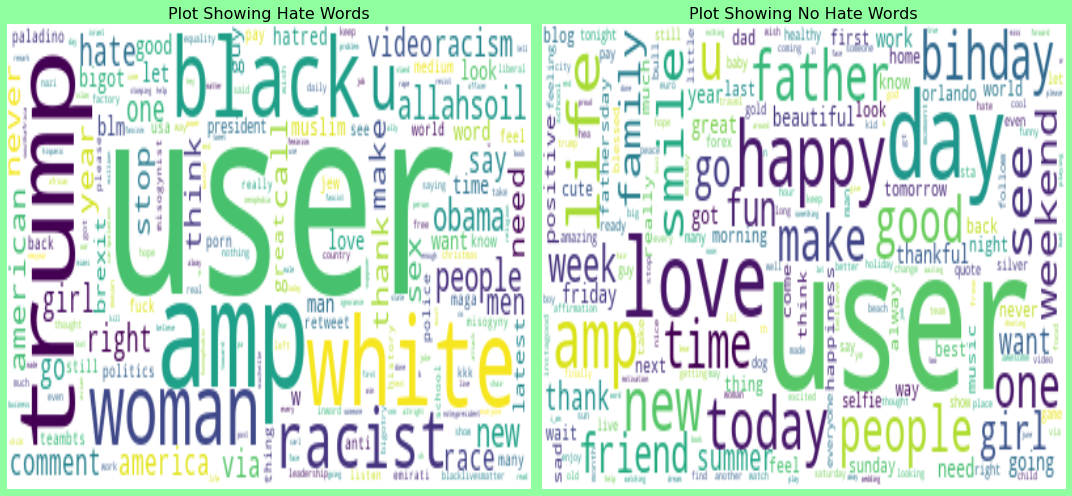

In [16]:
figure = plt.figure(figsize=[15, 7])
figure.patch.set_facecolor('xkcd:mint green')
plt.subplot(1, 2, 1)
plt.imshow(hate_word_cloud, interpolation='bilinear', aspect='auto')
plt.title(label='Plot Showing Hate Words', size=16)
plt.axis("off")

plt.subplot(1, 2, 2)
plt.imshow(nohate_words_cloud, interpolation='bilinear', aspect='auto')
plt.title(label='Plot Showing No Hate Words', size=16)
plt.axis("off")
plt.tight_layout()
plt.show()


#  Data Post-Processing



### Text Vectorizing - TFIDF


- This vectorized form of data will then be split and injected for model development.

In [17]:
vectorizer = TfidfVectorizer()
X = vectorizer.fit_transform(train_data['tweet'])
X_test = vectorizer.transform(test_data['tweet'])
y = train_data['label']
print('X Shape:', X.shape)
print('X_test Shape:', X_test.shape)

X Shape: (29530, 35554)
X_test Shape: (16130, 35554)



###  Data Splitting

- Let's split our data to train and validation set for model injection.

In [18]:
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

print('Training Data Shape:', X_train.shape, y_train.shape)
print('Validation Data Shape:', X_val.shape, y_val.shape)

Training Data Shape: (23624, 35554) (23624,)
Validation Data Shape: (5906, 35554) (5906,)



#  Model Development & Evaluation


- Now we will create different models (Logistic Regression and Multinomial Naive Bayes) to train and evaluate the performance of them.


### Logistic Regression

In [19]:
lr = LogisticRegression(class_weight='balanced', random_state=42, solver='lbfgs', max_iter=1000, n_jobs=-1)
lr.fit(X_train, y_train)

y_train_pred_count = lr.predict(X_train)
y_val_pred_count = lr.predict(X_val)

print('                   Training Report                   ')
print(classification_report(y_train, y_train_pred_count))

print('                   Testing Report                   ')
print(classification_report(y_val, y_val_pred_count))

                   Training Report                   
              precision    recall  f1-score   support

           0       1.00      0.96      0.98     22014
           1       0.66      0.99      0.79      1610

    accuracy                           0.96     23624
   macro avg       0.83      0.98      0.89     23624
weighted avg       0.98      0.96      0.97     23624

                   Testing Report                   
              precision    recall  f1-score   support

           0       0.98      0.95      0.97      5503
           1       0.55      0.78      0.64       403

    accuracy                           0.94      5906
   macro avg       0.77      0.87      0.81      5906
weighted avg       0.95      0.94      0.95      5906




###  Multinomial Naive Bayes

In [20]:
mn = MultinomialNB()
mn.fit(X_train, y_train)

y_train_pred_count = mn.predict(X_train)
y_val_pred_count = mn.predict(X_val)

print('                   Training Report                   ')
print(classification_report(y_train, y_train_pred_count))

print('                   Testing Report                   ')
print(classification_report(y_val, y_val_pred_count))

                   Training Report                   
              precision    recall  f1-score   support

           0       0.94      1.00      0.97     22014
           1       1.00      0.08      0.15      1610

    accuracy                           0.94     23624
   macro avg       0.97      0.54      0.56     23624
weighted avg       0.94      0.94      0.91     23624

                   Testing Report                   
              precision    recall  f1-score   support

           0       0.94      1.00      0.97      5503
           1       1.00      0.06      0.11       403

    accuracy                           0.94      5906
   macro avg       0.97      0.53      0.54      5906
weighted avg       0.94      0.94      0.91      5906



**Observation:**

- We can observe that **Logistic Regression performed better than Multinomial Naive Bayes** in terms of accuracy, precision, and recall.


###  New Predictions


#### New Predictions - Using Text

In [21]:
new_tweet = """
    Team India's defeat in T20 World Cup match against Pakistan on Sunday led to an angry army of trolls attacking pacer Mohammad Shami on social media.
    Soon after, several Indian cricketers including Sachin Tendulkar, Irfan Pathan and Virender Sehwag took to social media on Monday to extend their support to Shami.
    """

# Transforming raw data to clean data
review = [clean_data(new_tweet)]

# Vectorizing the input data
new_input = vectorizer.transform(review)

# Predicting label for the input tweet
prediction_label = lr.predict(new_input)
print('Label:', prediction_label)

Label: [0]



#### New Predictions - On Test Data

In [22]:
# Predicting label for the test data
test_data['label'] = lr.predict(X_test)
test_data.to_csv('test_results.csv', index=False)


#  Summarization



###  Conclusion


- We analyzed and understood the behavior of the data and performed manipulations accordingly.

- We performed several transformations over the twitter tweets as per the requirement.

- We tried out Logistic Regression and Multinomial Naive Bayes algorithm for training the model.

- It turns out that the Logistic Regression gave us the best accuracy on test data i.e. around 94%.
